In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os

# This solves this issue: "RuntimeError: MPS backend out of memory" when sending vgg19 to device
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

# Models and Parameters

In [3]:

# Params and Hyper Parameters:
hidden_sizes:tuple = (2048, 512)
learning_rate = 0.01
epochs = 20
folds = 5

use_batch_normalization=False
use_imagenet_weights=True
use_gpu_if_available = True

## Custom NN

In [4]:
def build_hidden_layers(hidden_sizes:tuple[int]):
    hidden_layers = []

    before_size = hidden_sizes[0]

    for hidden_size in hidden_sizes[1:]:
        hidden_layers += [
            nn.Linear(in_features=before_size, out_features=hidden_size) ,
            nn.ReLU(),
        ]
        before_size = hidden_size

    return hidden_layers

In [5]:
# References https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 

class NeuralNetwork(nn.Module):
    def __init__(self, input_size:int, hidden_sizes:tuple[int], output_size:int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            *build_hidden_layers(hidden_sizes),
            nn.Linear(hidden_sizes[-1], output_size),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        # x = self.flatten(x)
        return logits
    

## VGG Network

In [6]:
def get_vgg19_model(input_size:int, hidden_sizes:tuple[int], output_size:int, use_batch_normalization: bool, use_imagenet_weights:bool):
    import torchvision.models as models

    model = models.vgg19_bn if use_batch_normalization else models.vgg19

    vgg19 = model(
        # If weights is None, this needs to be true:
        init_weights = not use_imagenet_weights, 
        weights = "IMAGENET1K_V1" if use_imagenet_weights else None,

        # num_classes is ignored if we specify a classifier below:
        num_classes= 1000 if use_imagenet_weights else output_size,
    )

    # modify the final fully connected layer to get binary classification:
    # num_features = vgg19.classifier[6].in_features
    # vgg19.classifier[6] = torch.nn.Linear(num_features, output_size)

    # vgg19.avgpool= nn.AdaptiveAvgPool2d(output_size=(2, 2))

    # vgg19.classifier = nn.Sequential(
    #     # 6 divisor is a magic number, literally:
    #     nn.Linear(in_features=int(input_size / 6) , out_features=hidden_sizes[0]) ,
    #     nn.ReLU(),

    #     *build_hidden_layers(hidden_sizes),
        
    #     nn.Dropout(p=0.6),  # Do we need this here? 0.5 by default
            
    #     nn.Linear(in_features=hidden_sizes[-1] , out_features=output_size),
    #     # nn.LogSoftmax(dim=1)  
    # )
    if not use_imagenet_weights:
        vgg19.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.5),
                nn.Linear(4096, output_size),
            )

    return vgg19


## Running images on non-CPU:

Mac:
Run `brew install libjpeg`

In [7]:

# Init a device with cuda or mps so that it can train faster
from typing import Literal


device: Literal['cuda'] | Literal['mps'] | Literal['cpu'] = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = device if use_gpu_if_available else "cpu"
print(f"Using {device} device")

Using mps device


# Run Training and Test Functions

In [8]:

from time import time


def run_training(
        dataset_loader:DataLoader,
        model: nn.Module,
        optimizer: optim.Optimizer,
        epochs:int
        ):
    
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    losses = []

    start_time = time()
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        # Pass data to model:
        number_of_samples = len(dataset_loader)
        counter = 1
        for train_x, train_y in dataset_loader:
            print(f"Training {counter} of {number_of_samples}, epoch {epoch}")
            counter += 1
            train_x = train_x.to(device)
            train_y = train_y.to(device)

            optimizer.zero_grad()
            outputs = model(train_x)
            loss = criterion(outputs, train_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += train_y.size(0)
            correct += (predicted == train_y).sum().item()
            running_loss += loss.item()

        loss = running_loss / len(dataset_loader)
        losses.append(loss)

        train_accuracy = (correct / total) * 100
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.2f}%. Took {time()-start_time} seconds')
        
        start_time = time()

    return train_accuracies, losses

def run_test(test_loader: DataLoader, model: nn.Module,):
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x = test_x.to(device)
            test_y = test_y.to(device)

            outputs = model(test_x)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(test_y.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()


    accuracy: float = float(accuracy_score(all_labels, all_preds))
    recall = recall_score(all_labels, all_preds, average="binary") 
    f1 = f1_score(all_labels, all_preds, average="binary")
    
    output_text = f"""
Accuracy: {accuracy:.4f}
Recall: {recall:.4f}
F1 Score: {f1:.4f}
True Positives (TP): {tp}
False Positives (FP): {fp}
True Negatives (TN): {tn}
False Negatives (FN): {fn}
    """

    print(output_text)

    return accuracy, recall, f1, tn, fp, fn, tp, output_text

# Load dataset

In [9]:
%run ./dataset_load.py

dataset = load_from_images(device) # type: ignore

/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/shehab/anaconda3/envs/nn/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/shehab/anaconda3/envs/nn/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

In [10]:
number_of_features = dataset[0][0].numel()

print(number_of_features)

150528


In [11]:
number_of_classes = len(dataset.classes)
print("Number of classes:", number_of_classes, dataset.classes)

Number of classes: 2 ['defected', 'not_defected']


In [12]:
def save_model(model, fold_number:int, output_size:int, use_batch_normalization: bool, use_imagenet_weights:bool, output_folder:str):
    file_path = f"{output_folder}fold{fold_number}_outputs{output_size}_{'BN' if use_batch_normalization else 'noBN'}_{'imagenet' if use_imagenet_weights else 'no_imagenet'}.pth"
    print("Saving model to", file_path)
    torch.save(model.state_dict(), file_path)
    print("Saving done.")

# K-Fold and running the training and validation


Fold 1. Training samples 1133, Testing samples 284
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)
Training 1 of 9, epoch 0
Training 2 of 9, epoch 0
Training 3 of 9, epoch 0
Training 4 of 9, epoch 0
Training 5 of 9, epoch 0
Training 6 of 9, epoch 0
Training 7 of 9, epoch 0
Training 8 of 9, epoch 0
Training 9 of 9, epoch 0
Epoch 1/20, Loss: 2858.0855, Train Accuracy: 52.25%. Took 8.284428119659424 seconds
Training 1 of 9, epoch 1
Training 2 of 9, epoch 1
Training 3 of 9, epoch 1
Training 4 of 9, epoch 1
Training 5 of 9, epoch 1
Training 6 of 9, epoch 1
Training 7 of 9, epoch 1
Training 8 of 9, epoch 1
Training 9 of 9, epoch 1
Epoch 2/20, Loss: 7.8368, Train Accuracy: 85.17%. Took 7.468952178955078 seconds
Training 1 

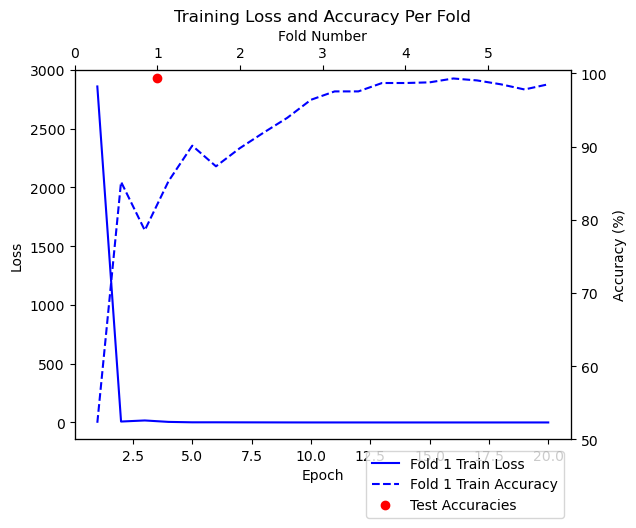

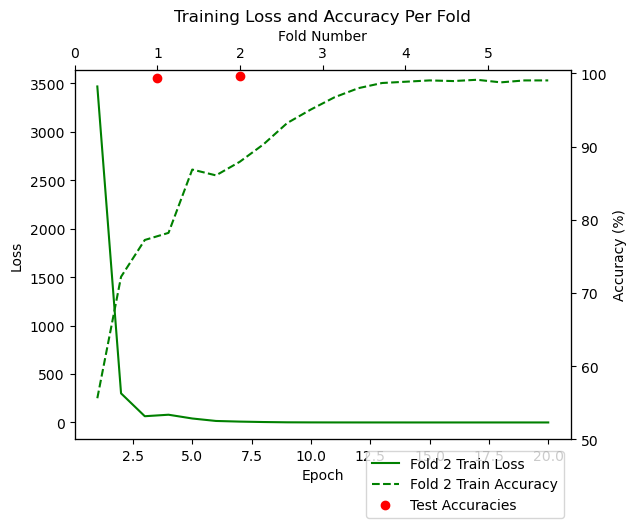

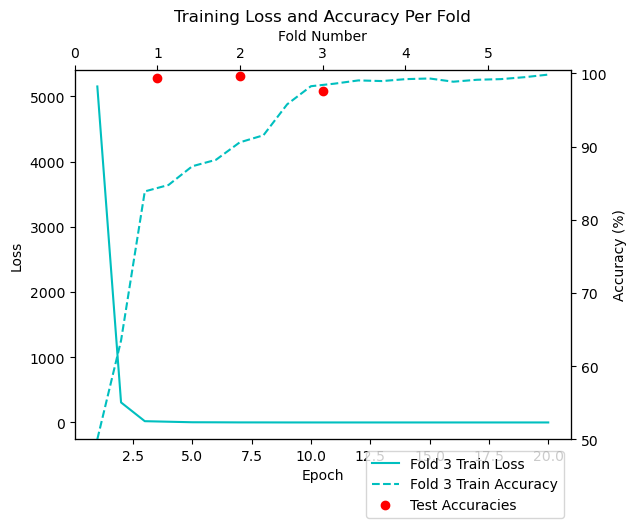

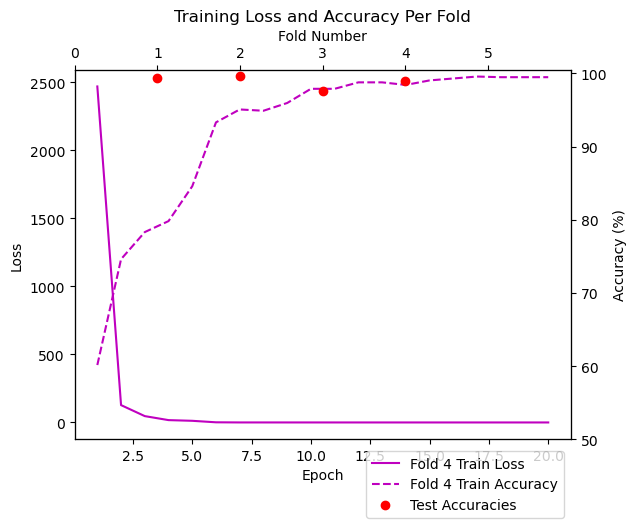

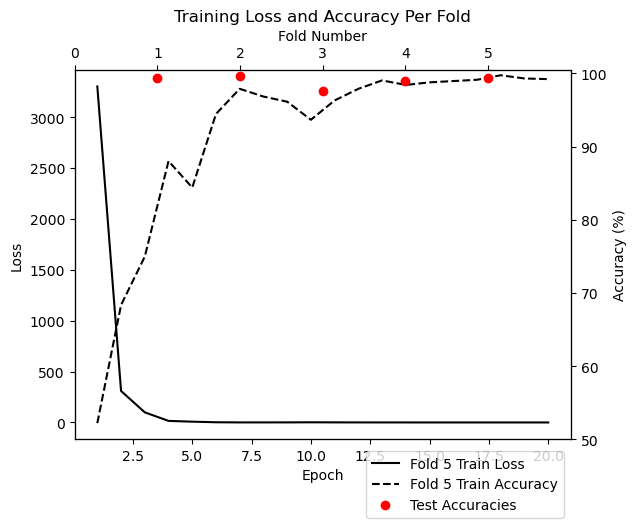

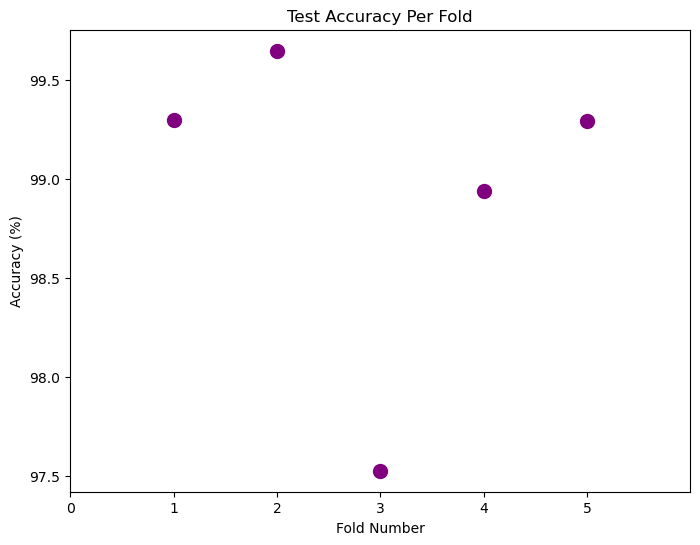

In [13]:

test_accuracies = [0.0]*folds
kfold = KFold(n_splits=folds, shuffle=True)
fold = 1
colors = 'bgcmk'
training_start_time = time()

output_folder = f"outputs/{training_start_time}/"

os.makedirs("outputs", exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

for train_idx, test_idx in kfold.split(dataset):
    print(f"Fold {fold}. Training samples {len(train_idx)}, Testing samples {len(test_idx)}")
    
    fold_index = fold-1

    # Init a fresh model
    model = NeuralNetwork(
        input_size=number_of_features, 
        hidden_sizes=hidden_sizes, 
        output_size=number_of_classes
    )
    # model = get_vgg19_model(
    #     input_size=number_of_features, 
    #     hidden_sizes=hidden_sizes, 
    #     output_size=number_of_classes,
    #     use_batch_normalization=use_batch_normalization,
    #     use_imagenet_weights=use_imagenet_weights
    # )
    model = model.to(device)

    print(model)

    # optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    
    # Create train and test subsets
    train_subset = Subset(dataset, train_idx.tolist())
    test_subset = Subset(dataset, test_idx.tolist())
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

    train_accuracies, train_losses = run_training(
        train_loader, 
        model, 
        optimizer, 
        epochs
    )

    save_model(
        model=model,
        fold_number=fold,
        output_size=number_of_classes,
        use_batch_normalization=use_batch_normalization,
        use_imagenet_weights=use_imagenet_weights,
        output_folder=output_folder
    )

    test_accuracy, recall, f1, tn, fp, fn, tp, output_text = run_test(test_loader, model)

    with open(f"{output_folder}results_fold{fold}.txt", "w") as fp:
        fp.write(output_text)

    test_accuracies[fold_index] = test_accuracy * 100

    # Plot for this fold
    fig, left_y_axis = plt.subplots()
    right_y_axis = left_y_axis.twinx()
    top_x_axis = right_y_axis.twiny()

    left_y_axis.plot(range(1, epochs + 1), train_losses, colors[fold_index]+'-',  label=f'Fold {fold} Train Loss')

    top_x_axis.plot([f+1 for f in range(folds)], test_accuracies, 'ro', label=f'Test Accuracies')

    right_y_axis.plot(range(1, epochs + 1), train_accuracies, colors[fold_index]+'--', label=f'Fold {fold} Train Accuracy')

    plt.title('Training Loss and Accuracy Per Fold')

    left_y_axis.set_xlabel('Epoch')
    left_y_axis.set_ylabel('Loss')

    right_y_axis.set_ylabel('Accuracy (%)')
    right_y_axis.set_ylim(50.0, 100.5)

    top_x_axis.set_xlim(0, folds+1)
    top_x_axis.set_xticks(range(folds+1))
    top_x_axis.set_xlabel("Fold Number")
    fig.legend( bbox_to_anchor=(0.9,0.1))
    fig.savefig(f'{output_folder}training_loss_fold{fold}.png', bbox_inches='tight') 

    fold += 1

plt.figure(figsize=(8, 6))
plt.scatter([f+1 for f in range(folds)], test_accuracies, color='purple', s=100, label='Test Accuracy')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy (%)')
plt.xlim(0, folds+1)
plt.xticks(range(folds+1))

plt.title('Test Accuracy Per Fold')

plt.savefig(f'{output_folder}test_accuracies.png', bbox_inches='tight') 

